# 사전 훈련된 VGG16을 이용한 특성추출

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

In [1]:
import tensorflow as tf; print(tf.__version__)

1.9.0


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 데이터 증식을 사용하지 않는 빠른 특성 추출

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
base_dir = "datasets/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1)  * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6221 - acc: 0.6530 - val_loss: 0.4380 - val_acc: 0.8300
Epoch 2/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4324 - acc: 0.7990 - val_loss: 0.3569 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3662 - acc: 0.8455 - val_loss: 0.3228 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3195 - acc: 0.8625 - val_loss: 0.3039 - val_acc: 0.8940
Epoch 5/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2994 - acc: 0.8745 - val_loss: 0.2825 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2673 - acc: 0.8930 - val_loss: 0.2727 - val_acc: 0.8810 lo
Epoch 7/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2537 - acc: 0.8940 - val_loss: 0.2669 - val_acc: 0.8870
Epoch 8/30


<function matplotlib.pyplot.show(*args, **kw)>

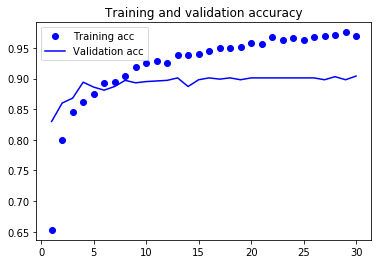

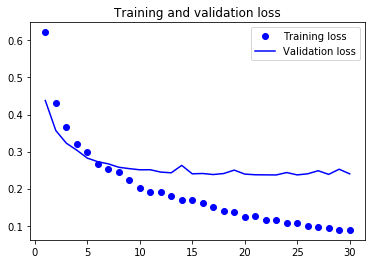

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show

## 데이터 증식을 사용한 특성 추출

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print("no freezing num : ",len(model.trainable_weights))

conv_base.trainable = False

print("yes freezing num : ", len(model.trainable_weights))

no freezing num :  30
yes freezing num :  4


In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:


model.compile(loss="binary_crossentropy",
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 451s - loss: 0.6083 - acc: 0.6775 - val_loss: 0.4532 - val_acc: 0.8200
Epoch 2/30
 - 451s - loss: 0.4839 - acc: 0.7775 - val_loss: 0.3793 - val_acc: 0.8560
Epoch 3/30
 - 472s - loss: 0.4365 - acc: 0.8035 - val_loss: 0.3397 - val_acc: 0.8590
Epoch 4/30
 - 426s - loss: 0.4002 - acc: 0.8260 - val_loss: 0.3142 - val_acc: 0.8830
Epoch 5/30
 - 421s - loss: 0.3829 - acc: 0.8300 - val_loss: 0.3066 - val_acc: 0.8710
Epoch 6/30
 - 422s - loss: 0.3707 - acc: 0.8290 - val_loss: 0.2866 - val_acc: 0.8850
Epoch 7/30
 - 419s - loss: 0.3578 - acc: 0.8500 - val_loss: 0.2826 - val_acc: 0.8930
Epoch 8/30
 - 30349s - loss: 0.3529 - acc: 0.8410 - val_loss: 0.2727 - val_acc: 0.8950
Epoch 9/30
 - 437s - loss: 0.3412 - acc: 0.8500 - val_loss: 0.2702 - val_acc: 0.8950
Epoch 10/30
 - 434s - loss: 0.3418 - acc: 0.8480 - val_loss: 0.2642 - val_acc: 0.8950
Epoch 11/30
 - 428s - loss: 0.3426 - acc: 0.8345 - val_loss: 0.

<function matplotlib.pyplot.show(*args, **kw)>

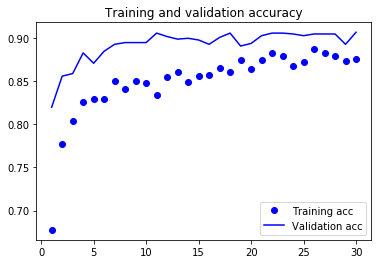

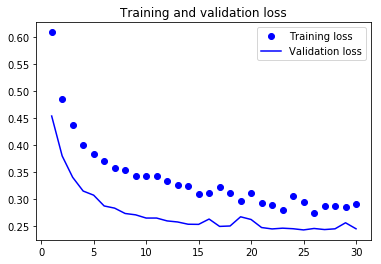

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show

## 미세조정

1. 사전에 훈련된 네트워크 위에 새 네트워크 추가
2. 기반 네트워크 동결
3. 추가 네트워크 훈련
4. 기반 네트워크에서 일부 층 동경 해제
5. 동경 해제 층과 새로 추가한 층을 훈련

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [11]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 하위층은 일반적이고 재사용 가능한 특성들을 인코딩하는 반면 상위층은 좀 더 특화된 특성을 인코딩한다.
#### 즉 새로운 문제에 재활용하도록 수정이 필요한 것은 상위층이다.

#### 위와 더불어 과적합 문제로 인해 최상위 2~3층만 미세 조정하는 것이 좋다.

In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 98s 980ms/step - loss: 0.5383 - acc: 0.7315 - val_loss: 0.3361 - val_acc: 0.8580
Epoch 2/100
100/100 [==============================] - 92s 917ms/step - loss: 0.3725 - acc: 0.8340 - val_loss: 0.2658 - val_acc: 0.8900
Epoch 3/100
100/100 [==============================] - 95s 948ms/step - loss: 0.3070 - acc: 0.8685 - val_loss: 0.2357 - val_acc: 0.8980
Epoch 4/100
100/100 [==============================] - 101s 1s/step - loss: 0.2845 - acc: 0.8810 - val_loss: 0.2012 - val_acc: 0.9110
Epoch 5/100
100/100 [==============================] - 106s 1s/step - loss: 0.2653 - acc: 0.8860 - val_loss: 0.1997 - val_acc: 0.9150
Epoch 6/100
100/100 [==============================] - 102s 1s/step - loss: 0.2408 - acc: 0.9045 - val_loss: 0.1894 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2393 - acc: 0.8985 - val_loss: 0.2118 - val_acc: 0.9130
Epoch 8/100
100/100 [==============================] -

Epoch 61/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0417 - acc: 0.9855 - val_loss: 0.2075 - val_acc: 0.9320
Epoch 62/100
100/100 [==============================] - 23s 226ms/step - loss: 0.0451 - acc: 0.9855 - val_loss: 0.2206 - val_acc: 0.9340
Epoch 63/100
100/100 [==============================] - 21s 205ms/step - loss: 0.0415 - acc: 0.9830 - val_loss: 0.3302 - val_acc: 0.9250
Epoch 64/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0394 - acc: 0.9865 - val_loss: 0.2204 - val_acc: 0.9380
Epoch 65/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0289 - acc: 0.9895 - val_loss: 0.3501 - val_acc: 0.9230
Epoch 66/100
100/100 [==============================] - 18s 175ms/step - loss: 0.0387 - acc: 0.9835 - val_loss: 0.1942 - val_acc: 0.9410
Epoch 67/100
100/100 [==============================] - 17s 174ms/step - loss: 0.0423 - acc: 0.9840 - val_loss: 0.1999 - val_acc: 0.9470
Epoch 68/100
100/100 [===================

<function matplotlib.pyplot.show(*args, **kw)>

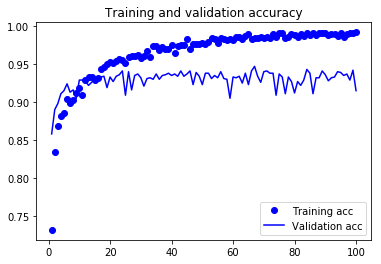

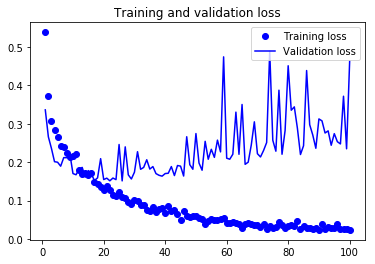

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

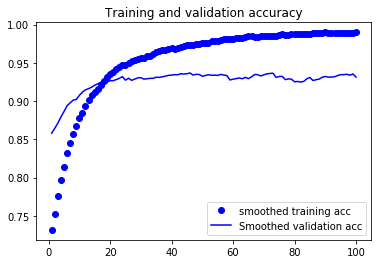

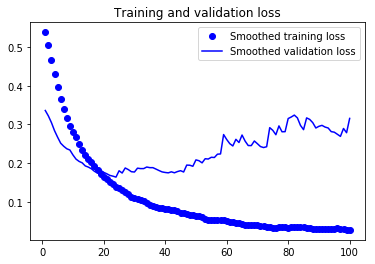

In [28]:
plt.plot(epochs,
        smooth_curve(acc), 'bo', label="smoothed training acc")
plt.plot(epochs,
        smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
        smooth_curve(loss), 'bo', label='Smoothed training loss')

plt.plot(epochs,
        smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc : ', test_acc)

Found 1000 images belonging to 2 classes.
test acc :  0.9069999957084656
